# Mortality Group Script 
Rustom Ichhaporia

In [6]:
# General imports used for data operations and plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import csv
import ast

# Scikit-learn imports for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

# Synthetic Minority Oversampling Technique for data balancing
from imblearn.over_sampling import SMOTE

# Final model format used for training
import lightgbm as lgb

# Hyperparameter optimization imports
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
from hyperopt.pyll.stochastic import sample
from timeit import default_timer as timer

# Set the default style for Seaborn
sns.set()

In [7]:
df_raw = pd.read_csv('data/11.csv').drop(['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse'], axis=1)
df_raw

,record,age,race,sex,ms,hisp,adjinc,educ,pob,wt,...,vt,histatus,hitype,povpct,stater,rcow,tenure,citizen,health,indalg
0,88426,70,1.0,2,5.0,3.0,11.0,4.0,909,151,...,0.0,NaN,NaN,18,16,4.0,1.0,NaN,NaN,1.0
1,88427,79,1.0,2,2.0,3.0,11.0,4.0,909,132,...,0.0,NaN,NaN,18,16,3.0,1.0,NaN,NaN,NaN
2,88428,34,1.0,1,1.0,3.0,8.0,4.0,909,155,...,0.0,NaN,NaN,10,16,1.0,2.0,NaN,NaN,1.0
3,88429,32,1.0,2,1.0,3.0,8.0,1.0,909,155,...,0.0,NaN,NaN,10,16,1.0,2.0,NaN,NaN,1.0
4,88430,2,1.0,2,NaN,3.0,8.0,NaN,909,145,...,NaN,NaN,NaN,10,16,NaN,2.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1835067,666,19,1.0,1,5.0,2.0,4.0,8.0,909,60,...,0.0,1.0,4.0,6,16,2.0,2.0,NaN,1.0,NaN
1835068,667,33,1.0,2,1.0,2.0,11.0,6.0,909,56,...,0.0,1.0,4.0,10,16,NaN,2.0,1.0,1.0,NaN
1835069,668,16,1.0,2,5.0,2.0,11.0,6.0,909,60,...,0.0,1.0,4.0,10,16,NaN,2.0,NaN,1.0,NaN
1835070,669,7,1.0,2,NaN,2.0,11.0,NaN,909,51,...,NaN,1.0,4.0,10,16,NaN,2.0,1.0,1.0,NaN


Because this data takes a long time to compile and verify from multiple smaller studies, the creators included both a definite and an algorithmic indicator of death to speed up the release of the data. These features, `'inddea'` and `'indalg'`, respectively, have been combined through intersection into one target variable, `'indmort'` in the way that the reference manual recommends. The expanded list of features is below. 

In [8]:
# indmort is the recommended combination feature of both confirmed deaths and computer-predicted deaths based on the data collection agency
df_raw['indmort'] = df_raw['inddea'][(df_raw['inddea'] == 1) & (df_raw['indalg'] == 1)]
df_raw['indmort'] = df_raw['indmort'].fillna(0)
df_raw['indmort'].sum()

94107.0

In [9]:
numerical = ['age', 'hhnum']
uneven_numerical = ['adjinc', 'health', 'follow']
categorical = ['race', 'sex', 'ms', 'hisp', 'educ', 'pob', 'hhid', 'reltrf', 'occ', 'majocc', 'ind', 'esr', 'urban', 'smsast', 'inddea', 'cause113', 'dayod', 'hosp', 'hospd', 'ssnyn', 'vt', 'histatus', 'hitype', 'povpct', 'stater', 'rcow', 'tenure', 'citizen', 'indalg']
smoking = ['smok100', 'agesmk', 'smokstat', 'smokhome', 'curruse', 'everuse']
misc = ['record', 'wt']


<pre>List of all the features and their full names is pasted below. For the full description of the features, refer to the read_pubfile5.dat file. 
@1 record     $   7.     /*Record Number (page no. 6)                              */
    @8 age            2.     /*Age at Time of Interview (page no. 10)                  */
    @10 race      $   1.     /*Race  (page no.12)                                      */
    @11 sex       $   1.     /*Sex   (page no.10)                                      */
    @12 ms        $   1.     /*Marital Status (page no.13)                             */
    @13 hisp      $   1.     /*Hispanic Origin (page no. 12)                           */
    @14 adjinc    $   2.     /*Inflation Adjusted Income (page no.20)                  */
    @16 educ      $   2.     /*Highest Grade Completed (page no.14)                    */
    @18 pob       $   3.     /*Region of Birth (page no. 11)                           */
    @21 wt            4.     /*Adjusted Weight (page no. 6 )                           */
    @25 hhid      $   7.     /*Household ID No. (page no. 6)                           */
    @32 hhnum         2.     /*Number of People in HH (page no. 14)                    */
    @34 reltrf    $   1.     /*Relationship to Reference Person (page no.13)           */
    @35 occ       $   4.     /*4 Digit Occupation Code (page no. 18)                   */
    @39 majocc    $   2.     /*Major Occupation Code (page no. 18 )                    */
    @41 ind       $   4.     /*4 Digit Industry Code (page no. 17)                     */
    @45 majind    $   2.     /*Major Industry Code (page no. 18)                       */
    @47 esr       $   1.     /*Employment Status Recode (page no. 17)                  */
    @48 urban     $   1.     /*Urban/Rural Status (page no. 8)                         */
    @49 smsast    $   1.     /*SMSAST Status (page no.9)                               */
    @50 inddea    $   1.     /*Death Indicator (page no. 23)                           */
    @51 cause113  $   3.     /*Cause of Death (page no. 23)                            */
    @54 follow        4.     /*Length of Follow-up (page no. 24)                       */
    @58 dayod     $   1.     /*Day of Week of Death (page no. 24)                      */
    @59 hosp      $   1.     /*Hospital Type (page no.25)                              */
    @60 hospd     $   1.     /*Hospital Death Indicator (page no. 26)                  */
    @61 ssnyn     $   1.     /*Presence of SSN (page no. 7)                            */
    @62 vt        $   1.     /*Veteran Status (page no. 16)                            */
    @63 histatus  $   1.     /*Health Insurance Status (page no. 22)                   */
    @64 hitype    $   1.     /*Health Insurance Type (page no. 22)                     */
    @65 povpct    $   2.     /*Income as Percent of Poverty Level (page no. 21)        */
    @67 stater    $   2.     /*State Recode (page no. 8)                               */
    @69 rcow      $   2.     /*Recoded Class of Worker (page no.19)                    */
    @71 tenure    $   1.     /*Housing Tenure (page no. 14)                            */
    @72 citizen   $   1.     /*Citizenship (page no. 16)                               */
    @73 health    $   2.     /*Health (page no. 16)                                    */
    @75 indalg        1.     /*Indicator of Algorithmic Death (page no. 27)            */
    @76 smok100   $   1.     /*Smoked More than 100 Cigarettes (page no. 28)           */
    @77 agesmk    $   2.     /*Age Started Smoking (page no. 28)                       */
    @79 smokstat  $   1.     /*Cigarette Smoking Status (page no.28)                   */
    @80 smokhome  $   1.     /*Rules for Smoking Cigarettes in the Home (page no. 29 ) */
    @81 curruse   $   5.     /*Currently Use Smokeless Tobacco (page no. 30)           */
    @86 everuse   $   5.     /*Ever Use Smokeless Tobacco (page no. 31)                */</pre>

For exploratory data analysis purposes, only a few variables have been selected. Several of the other variables available in the dataset are largely irrelevant to the cause of death, post-mortem statistics (e.g. `cause113`), or have very high missing rates (e.g. `health` has a missing rate of nearly 80% because it is self reported). 

In [18]:
used_features = ['age', 'sex', 'stater', 'povpct', 'pob', 'race', 'urban', 'ms', 'adjinc', 'educ', 'indmort', 'wt']#, 'educ', 'stater']#, 'wt']
df = df_raw[used_features]

Correlations can be useful for numerical features, but most of these features are categorical, so I decided to begin one-hot encoding and imputation of missing values. I then convert the data types of the non-numerical features to category. Each entry has an associated weight, but those have not yet been factored in. 

In [23]:
df = df.astype({'sex':'category', 'stater': 'category', 'pob': 'category', 'race': 'category', 'urban': 'category', 'ms': 'category'})
df = df.astype({'educ':'category', 'stater':'category'})
df.dtypes

age           int64
sex        category
stater     category
povpct        int64
pob        category
race       category
urban      category
ms         category
adjinc      float64
educ       category
indmort     float64
wt            int64
dtype: object

In [24]:
df.corr()

,age,povpct,adjinc,indmort,wt
age,1.000000,0.123609,-0.069941,0.336753,0.013393
povpct,0.123609,1.000000,0.895188,-0.026255,0.043157
adjinc,-0.069941,0.895188,1.000000,-0.098752,0.022510
indmort,0.336753,-0.026255,-0.098752,1.000000,0.005620
wt,0.013393,0.043157,0.022510,0.005620,1.000000


In [25]:
df

,age,sex,stater,povpct,pob,race,urban,ms,adjinc,educ,indmort,wt
0,70,2,16,18,909,1.0,1.0,5.0,11.0,4.0,0.0,151
1,79,2,16,18,909,1.0,1.0,2.0,11.0,4.0,0.0,132
2,34,1,16,10,909,1.0,1.0,1.0,8.0,4.0,0.0,155
3,32,2,16,10,909,1.0,1.0,1.0,8.0,1.0,0.0,155
4,2,2,16,10,909,1.0,1.0,NaN,8.0,NaN,0.0,145
...,...,...,...,...,...,...,...,...,...,...,...,...
1835067,19,1,16,6,909,1.0,1.0,5.0,4.0,8.0,0.0,60
1835068,33,2,16,10,909,1.0,1.0,1.0,11.0,6.0,0.0,56
1835069,16,2,16,10,909,1.0,1.0,5.0,11.0,6.0,0.0,60
1835070,7,2,16,10,909,1.0,1.0,NaN,11.0,NaN,0.0,51


In [26]:
df['indmort'].value_counts(normalize=True)

0.0    0.948718
1.0    0.051282
Name: indmort, dtype: float64

In [27]:
df.shape

(1835072, 12)

In [28]:
(df.isna().sum() / df.shape[0]).sort_values()

age        0.000000
sex        0.000000
stater     0.000000
povpct     0.000000
pob        0.000000
indmort    0.000000
wt         0.000000
race       0.001575
urban      0.007107
adjinc     0.024124
educ       0.191202
ms         0.196846
dtype: float64

The call to `get_dummies()` will convert all the categorical features into individual binary columns. I have also dropped rows with missing values. 

In [31]:
df_dropped = df.dropna(axis=0)
df_dropped = pd.get_dummies(df_dropped)

In [32]:
df_dropped.shape

(1443262, 147)

The Synthetic Minority Oversampling Technique (SMOTE) resamples the minority class (in this case, entries of people who have died) to make it easier for a classification model to predict the difference. However, it is only run on the training set, not the test set, so that the natural frequency of death is preserved when testing the performance of the model. 

In [35]:
y = df_dropped['indmort']
X = df_dropped.drop(columns=['indmort'])
print('Dead / alive ratio before SMOTE:', y.sum() / y.shape[0])

Dead / alive ratio before SMOTE: 0.06430156132427792


The `train_test_split()` function converts the X and y DataFrames into train and test sets for the model. 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [37]:
# Only use oversampling for the train dataset, use regular distribution for testing
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
print('Dead / alive ratio after SMOTE:', y_train.sum() / y_train.shape[0])

Dead / alive ratio after SMOTE: 0.5


Now, I implement a LightGBM classififer model and iterate through a hypermparameter space to find the best performing model. A suggested number of evaluations was 150. The below code is partially taken from this source: 
https://www.kaggle.com/willkoehrsen/automated-model-tuning 

In [38]:
train_set = lgb.Dataset(X_train, label=y_train)

In [39]:
# Below code is from Jiaxin and Jingbin 

MAX_EVALS = 5
N_FOLDS = 3

def objective(params, n_folds = N_FOLDS):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Retrieve the subsample if present otherwise set to 1.0
    subsample = params['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    
    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(params, train_set, num_boost_round = 1000, nfold = n_folds, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    # print(cv_results)
    
    run_time = timer() - start
    
    # Extract the best score
    # best_score = np.min(cv_results['mse-mean'])
    best_score = np.max(cv_results['auc-mean'])
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the lowest cv score
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)

    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

In [27]:
space = {
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)
}
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9864416326585367,
 'learning_rate': 0.060025627594363265,
 'min_child_samples': 245.0,
 'num_leaves': 75.0,
 'reg_alpha': 0.06728569341468615,
 'reg_lambda': 0.8998191545637946,
 'subsample_for_bin': 220000.0,
 'subsample': 0.551248433618183}

In [28]:
# optimization algorithm
tpe_algorithm = tpe.suggest

In [29]:
# Keep track of results
bayes_trials = Trials()

In [30]:
# File to save first results
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [31]:
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 5/5 [11:17<00:00, 135.55s/trial, best loss: 0.009053589281652008]


In [32]:
# Sort the trials with lowest loss (lowest MSE) first
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
bayes_trials_results[:2]

[{'loss': 0.009053589281652008,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.8970523178797932,
   'learning_rate': 0.035742378218536576,
   'min_child_samples': 45,
   'num_leaves': 138,
   'reg_alpha': 0.5005020213127344,
   'reg_lambda': 0.45121616279208887,
   'subsample_for_bin': 260000,
   'subsample': 0.6614743075688195},
  'iteration': 2,
  'estimators': 1000,
  'train_time': 299.79700322198914,
  'status': 'ok'},
 {'loss': 0.010676149743638619,
  'params': {'boosting_type': 'gbdt',
   'colsample_bytree': 0.620649129448606,
   'learning_rate': 0.017934544496484815,
   'min_child_samples': 260,
   'num_leaves': 30,
   'reg_alpha': 0.2092981310373776,
   'reg_lambda': 0.8946886330215067,
   'subsample_for_bin': 20000,
   'subsample': 0.8731487506937664},
  'iteration': 5,
  'estimators': 1000,
  'train_time': 263.6446141789929,
  'status': 'ok'}]

In [33]:
results = pd.read_csv('gbm_trials.csv')

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,0.009054,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",2,1000,299.797003
1,0.010676,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",5,1000,263.644614
2,0.022391,"{'boosting_type': 'goss', 'colsample_bytree': ...",1,53,48.269464
3,0.025200,"{'boosting_type': 'goss', 'colsample_bytree': ...",3,17,31.476822
4,0.026597,"{'boosting_type': 'goss', 'colsample_bytree': ...",4,12,34.531737


In [34]:

# Convert from a string to a dictionary
ast.literal_eval(results.loc[0, 'params'])

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8970523178797932,
 'learning_rate': 0.035742378218536576,
 'min_child_samples': 45,
 'num_leaves': 138,
 'reg_alpha': 0.5005020213127344,
 'reg_lambda': 0.45121616279208887,
 'subsample_for_bin': 260000,
 'subsample': 0.6614743075688195}

In [35]:
# Extract the ideal number of estimators and hyperparameters
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

In [63]:
data1,data2 = train_test_split(df, train_size = 0.8, random_state = 42)
n1 = data1.shape[0]
data1.index=pd.Series(range(0,n1))
n2 = data2.shape[0]
data2.index=pd.Series(range(0,n2))

In [64]:
X_train = data1.drop(['indmort'], axis=1)
y_train = data1['indmort']
X_test = data2.drop(['indmort'], axis=1)
y_test = data2['indmort']

In [76]:
# Re-create the best model and train on the training data
best_bayes_model = lgb.LGBMClassifier(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                       objective = 'binary', random_state = 50, **best_bayes_params)
best_bayes_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.8970523178797932,
               learning_rate=0.035742378218536576, min_child_samples=45,
               n_estimators=1000, num_leaves=138, objective='binary',
               random_state=50, reg_alpha=0.5005020213127344,
               reg_lambda=0.45121616279208887, subsample=0.6614743075688195,
               subsample_for_bin=260000)

In [77]:
preds = best_bayes_model.predict_proba(X_test)[:, 1]
print('The best model from Bayes optimization scores {:.5f} AUC ROC on the test set.'.format(roc_auc_score(y_test, preds)))

The best model from Bayes optimization scores 0.90201 AUC ROC on the test set.


In [78]:
preds

array([0.00419413, 0.0041355 , 0.07653413, ..., 0.00538721, 0.04496414,
       0.02533242])

In [79]:
print(classification_report(y_test, preds.round()))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    348185
         1.0       0.59      0.16      0.25     18830

    accuracy                           0.95    367015
   macro avg       0.77      0.58      0.61    367015
weighted avg       0.94      0.95      0.94    367015



In [80]:
print(classification_report(y_test, (preds + 0.25).round()))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97    348185
         1.0       0.40      0.48      0.44     18830

    accuracy                           0.94    367015
   macro avg       0.69      0.72      0.70    367015
weighted avg       0.94      0.94      0.94    367015



The predictions are best when a constant is added to the final probabilities. While the ROC/AUC score of the model after parameter tuning jumps from 0.73 to 0.9, the precision and recall of the minority class are relatively unchanged. I tried changing the loss function to auc, but the results were almost identical. 

In [181]:
probs = []
for i in range(10, 100, 10):
    temp = X_train.iloc[0:1000]
    temp['age'] = 90
    probs.append(best_bayes_model.predict_proba(temp)[:, 1])

In [182]:
probs_clean = []
for item in probs:
    for value in item: 
        probs_clean.append(value)

In [183]:
len(probs_clean)

9000

<AxesSubplot:ylabel='Count'>

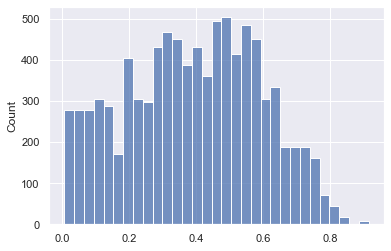

In [184]:
sns.histplot(data=probs_clean)

In [185]:
max(probs_clean)

0.9157495628424996

In [186]:
print(len([i for i in probs_clean if i > 0.5]) / len(probs_clean))

0.328


With the ages of everyone adjusted to 90, this is telling us that roughly a third of them would die within a decade. We can also look at the total distribution, which will be much more skew right because most people in the population are still too young to have a high likelihood of dying. 

In [187]:
probs = []
for i in range(10, 100, 10):
    temp = X_train.iloc[0:1000]
    temp['age'] = i
    probs.append(best_bayes_model.predict_proba(temp)[:, 1])
probs_clean = []
for item in probs:
    for value in item: 
        probs_clean.append(value)

<AxesSubplot:ylabel='Count'>

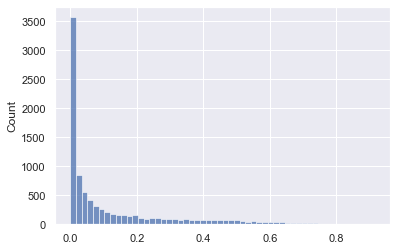

In [188]:
sns.histplot(data=probs_clean)

In [189]:
print(len([i for i in probs_clean if i > 0.5]) / len(probs_clean))

0.06133333333333333


As expected, roughly 1 out of 20 people without adjusted ages will die within a decade, which is close to the ratio of the training data. 

Below is some code that I had used previously 

In [ ]:
# X_wt = X_train['wt']
# X_train = X_train.drop(columns=['wt'])
# X_test = X_test.drop(columns=['wt'])

In [27]:
model = lgb.LGBMClassifier(is_unbalance=True, max_depth=20)
model.fit(X_train, y_train)

LGBMClassifier(is_unbalance=True, max_depth=20)

In [28]:
y_pred = model.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94    337447
         1.0       0.32      0.56      0.41     23369

    accuracy                           0.89    360816
   macro avg       0.64      0.74      0.67    360816
weighted avg       0.93      0.89      0.91    360816



In [30]:
roc_auc_score(y_test, y_pred)
# metrics.auc(fpr, tpr)

0.7399945389401491

estimators, 

In [31]:
# average_precision_score(y_test, y_pred) # sample_weight=X_test.wt

In [32]:
# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01],# , 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#     # "min_samples_split": np.linspace(0.1, 0.5, 12),
#     # "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[5],#[3,5,8],
#     # "max_features":["log2","sqrt"],
#     # "criterion": ["roc"],# ["friedman_mse",  "mae"],
#     "criterion": ["friedman_mse"],
#     # "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
#     "n_estimators":[100]
# }

# model = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

# model.fit(X_train, y_train)